# Regulatron: Experimento de classificação 2

O Experimento de classificação 2 foi a segunda experiência no tratamento dos dados brutos obtidos no Regulatron, a ferramenta de raspagem de dados veiculados em anúncios de produtos para telecomunicações publicados em alguns dos principais marketplaces do país. 

De forma geral, o experimento consiste na construção de um classificador automático, utilizando algoritmos de aprendizagem de máquina, para identificar anúncios de produtos passíveis de homologação compulsória pela Anatel. 

A abordagem utilizada foi classificação de texto por aprendizagem de máquina supervisionada. Classificação de texto, ou categorização de texto, é a técnica empregada para analisar documentos e a eles atribuir categorias previamente definidas. Nessa abordagem é utilizado um conjunto de dados rotulados para treinamento, ou seja, um conjunto de anúncios previamente analisados por um humano, indicando os produtos anunciados são passíveis de homologação compulsória pela Anatel.

A figura a seguir ilustra um sistema típico de classificação de texto por aprendizagem de máquina supervisionada. 

![Classificador de texto](assets/supervised_text_classification.png)


Na fase de treinamento, os anúncios classificados manualmente são transformados de texto bruto para um formato adequado para o algoritmo de aprendizagem de máquina, a partir do qual um classificador é construído. 

Uma vez treinado, o sistema é capaz de analisar novos anúncios, classificando-os de forma similar a um humano, e identificar os anúncios de produtos passíveis de homologação compulsória pela Anatel.pela Anatel.

## Bibliotecas



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import unidecode
import warnings 

from joblib import dump, load

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from string import punctuation

from tabulate import tabulate

from wordcloud import WordCloud

## Constantes e funções auxiliares

In [2]:
NULL_STRING = '#NULLO#'
MAX_CAT_COUNT = 3

In [3]:
def plot_donut(labels,values,title,startangle=30):
    fig, ax = plt.subplots(figsize=(5, 3), subplot_kw=dict(aspect="equal"))
    
    wedges, texts = ax.pie(values, wedgeprops=dict(width=0.5), startangle=startangle)
    
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props,
              zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    
    ax.set_title(title)
    plt.show()

In [4]:
def tokenizer(doc):
    doc = doc.lower()
    doc = unidecode.unidecode(doc)
    
    # uniformizar termos
    patterns = [('wi\s?.?fi', 'wifi'), 
                ('2,4', '2.4'), 
                ('5,8', '5.8')]
    for pattern, repl in patterns:
        doc = re.sub(pattern, repl, doc)
    
    stop_words = stopwords.words('portuguese')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(list(punctuation))
    # stopwords específicas do domínio
    stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver', 'unidades', 'fio', 'universal'])
    # cores mais comumns
    stop_words.extend(['preto', 'cinza', 'branco', 'rosa', 'vermelho', 'laranja', 'amarelo', 'verde', 'azul', 'roxo', 'marrom'])
    # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", que pode ser relevante para o domínio
    # stop_words.remove('sem') 
    
    tokens = [token for token in word_tokenize(doc) if token not in stop_words]

    tokens = [token for token in re.findall(r'\b\w\w+\b',doc) if token not in stop_words]
    
    return tokens

def clean_text(doc):
    tokens = tokenizer(doc)
    return ' '.join(tokens) 

In [5]:
def plot_wordcloud(wc_docs,max_words=50,ax=None,title='Principais palavras'):

    if hasattr(wc_docs, '__iter__'):
        wc_docs = ' '.join(wc_docs)
   
    wc = WordCloud(max_words=max_words,height=300).generate(wc_docs)

    if ax is None:
        fig,ax = plt.subplots(figsize=(5,5))
        show_plt = True
    else: 
        show_plt = False
    
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(title)

    if show_plt:
        plt.show()

In [44]:
def plot_produtcs_matrix(docs_matrix, targets=None, title=None, showlegend=False, legend_map=None, ax=None):
    
    pca = TruncatedSVD(n_components=2)
    pca_matrix = pca.fit_transform(docs_matrix)
    scatter_x = pca_matrix[:, 0] # first principle component
    scatter_y = pca_matrix[:, 1] # second principle component

    if ax is None:
        fig,ax = plt.subplots(figsize=(6,5))
        showplot = True
    else:
        showplot = False
    
    for group in np.unique(targets):
        if legend_map is not None:
            group_label = legend_map[group]
        else:
            group_label = group
        ix = np.where(targets == group)
        ax.scatter(scatter_x[ix], scatter_y[ix], label=group_label, s=5)
        if title is not None:
            ax.set_title(title)
    
    ax.set_xticks([])
    ax.set_yticks([])

    if showlegend:
        ax.legend()

    if showplot:
        plt.show()

## Anúncios extraídos da Amazon.com.br

A base de dados utilizada neste experimento contém 151.782 anúncios raspados do *marketplace* Amazon.com.br. Os anúncios são distribuídos originalmente em 30 categorias, entretando dois terços dos anúncios não contém categoria (a raspagem não trouxe a categoria do anúncio) e o restante se concentra, majoritariamente, em duas categorias: *Eletrônicos e Tecnologia* e *Computadores e Informática*.

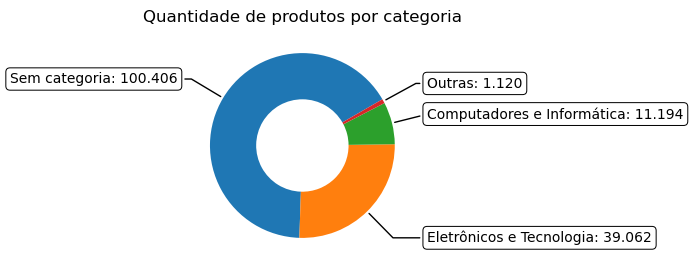

In [6]:
file_amazon = 'assets/amazon.parquet'
df_amazon = pd.read_parquet(file_amazon)

columns_to_keep = ['cat_0', 'Nome']
df_categories = df_amazon[columns_to_keep].groupby('cat_0',as_index=False).count().sort_values(by='Nome',ascending=False)
df_categories = df_categories.reset_index(drop=True)
df_categories.columns = ['cat_0', 'count']

map_cat_0 = {k:(v if v < MAX_CAT_COUNT else MAX_CAT_COUNT) for v,k in df_categories.cat_0.to_dict().items()}
df_categories['cat_0_int'] = df_categories['cat_0'].map(map_cat_0)

df_categories['cum_sum'] = df_categories['count'].cumsum()
df_categories['cum_part'] = df_categories['cum_sum'].apply(lambda x: x/df_categories['count'].sum()*100)

columns_to_keep = ['cat_0_int', 'count']
df_top_categories = df_categories[columns_to_keep].groupby('cat_0_int',as_index=False).sum()
reverse_map_cat_0 = {0: 'Sem categoria', 1: 'Eletrônicos e Tecnologia', 2: 'Computadores e Informática', 3: 'Outras'}
df_top_categories['top_cat'] = df_top_categories['cat_0_int'].map(reverse_map_cat_0)

columns_to_keep = ['top_cat', 'count']
df_top_categories = df_top_categories.set_index('cat_0_int')
df_top_categories = df_top_categories[columns_to_keep]

columns_to_keep = ['Categoria', 'Quantidade']
df_top_categories.columns = columns_to_keep

total_items = df_top_categories['Quantidade'].sum()
df_top_categories.loc[MAX_CAT_COUNT+1] = ['Total', total_items]

labels = df_top_categories.apply(lambda row: f'{row.Categoria}: {row.Quantidade:,d}'.replace(',','.'),axis=1)
values = df_top_categories.iloc[:-1,1].to_numpy()
title = 'Quantidade de produtos por categoria'
startangle = 30

plot_donut(labels, values, title, startangle)


## Categorias definidas pelos vendedores

A maioria das aplicações de classificação de texto é baseada em técnicas estatísticas, para tanto é necessário que cada texto contenha atributos (palavras) capazes de agrupa-los em determinada classe e, ao mesmo tempo, diferencia-los das demais classes. 

A primeira hipótese testada foi utilizar o título do anúncio para identificar e produto e as categorias informadas pelos anunciantes como fator de agrupamento. 

O texto bruto extraído diretamente dos anúncios não é adequado para utilização em algoritmos de aprendizagem de máquina. O primeiro passo para preparar o texto é o pré-processamento: todas as palavras foram transformadas para mínúsculas, foram retirados caracteres especiais, números e as palavras mais frequentes, que não carregam valor semântico e, portanto, são irrelevantes para identificação do produto, como por exemplo as palavras  "de", "para", "com", "por", etc.

Como resultado desta primeira análise identificou-se que a categoria informada pelos vendedores não é a melhor escolha para identificar corretamente os produtos passíveis de homologação compulsória pela Anatel. Observa-se, por exemplo, que as palavras transmissor e receptor estão presentes em todas as categorias e a palavra *bluetooth* é signitivamente relevante para a categoria Outras.

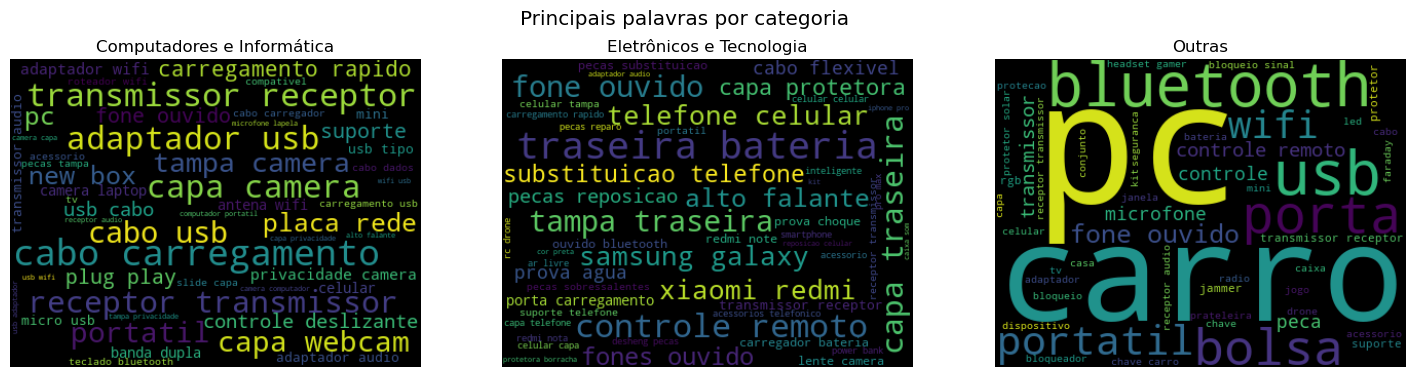

In [7]:
columns_to_keep = ['Nome','cat_0']
df_docs = df_amazon[df_amazon['cat_0']!=NULL_STRING][columns_to_keep]
df_docs['cat_0_id'] = df_docs['cat_0'].map(map_cat_0)
df_docs['cat_0'] = df_docs['cat_0_id'].map(reverse_map_cat_0)

docs = df_docs['Nome'].map(clean_text).values
targets = df_docs['cat_0'].values

fig,axs=plt.subplots(1,3,figsize=(18,4.2))

for i,target in enumerate(np.unique(targets)):
    ix = np.where(targets==target)[0]
    plot_wordcloud(docs[ix],ax=axs[i],title=target)

fig.suptitle('Principais palavras por categoria',fontsize='x-large')   
plt.show()

## Agrupamento de anúncios pelo título

Avançando na análise foi testada a hipótese de agrupamento dos anúncios utilizando o método *k-means*, que busca agrupar um conjunto de dados em subconjuntos menores por proximidade. A partir da definição da quantidade de subconjuntos que se deseja obter o algoritmo determina pontos centrais (centróide) para cada subconjunto e agrupa em torno deles os elementos mais próximos, considerando, como fator de proximidade, a distância euclidiana entre cada elemento do conjunto e a centróide de cada subconjunto.

Os títulos, já pré processados, foram convertidos em uma matriz de valores numéricos do modelo *bag-of-words*, na qual cada linha corresponde a um documento e cada coluna corresponde a uma palavra do vocabulário. Para ilustrar o modelo *bag-of-words*, suponhamos que foram transformados dois anúncios com a seguinte descrição:

- Fone de Ouvido Bluetooth Branco
- Alto-falante Bluetooth 5.0 Preto

que, após o pré processamento, foram transfomados para:

- fone ouvido bluetooth
- alto falante bluetooth

O vocabulário do conjunto de documentos (os dois títulos dos anúncios) é *alto*, *bluetooth*, *falante*, *fone*, *ouvido*, e a partir dele cada título é transformado em um vetor de tamanho fixo, definido pela quantidade de palavras, no qual cada elemento corresponde a um número associado à palavra presente no título. No modelo *[bag-of-words](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)* mais básico é indicada a presença ou ausência da palavra no documento. No exemplo aprentado a matriz resultante será de dimensão 2 linhas x 5 colunas:

$$
\begin{array}{lcc}
\hline & \text { alto } & \text { bluetooth } & \text { falante } & \text { fone } & \text { ouvido }\\
\hline \text { fone ouvido bluetooth } & 0 & 1 & 0 & 1 & 1 \\
\hline \text { alto falante bluetooth } & 1 & 1 & 1 & 0 & 0 \\
\hline
\end{array}
$$

Para esse teste de hipótese foi utiliza a variante *tf-idf* do modelo *bag-of-words*, no qual são consideradas a frequência da palavra no documento e sua frequência inversa no conjunto de documentos, minimizando o efeito de títulos com diferentes tamanhos (quantidades de palavras) e minimizando a importância de palavras que aparecem em muitos anúncios. 

Como resultado desta análise observou-se que o método *k-means* agrupou anúncios de forma satisfatória produtos semelhantes em um mesmo subgrupo. Ainda é visível alguma sobreposição entre os subgrupos, mas pode-se observar que no subgrupo 2 predominam acessórios e peças de substituição para celulares (capas, cabos, tampa, etc), indicando a viabilidade de prosseguir o experimento.

Para saber mais sobre *k-means* e *bag-of-words*, acesse: [K-means clustering](https://scikit-learn.org/stable/modules/clustering.html#k-means), [What is bag of words?](https://www.ibm.com/topics/bag-of-words) e [Text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction).

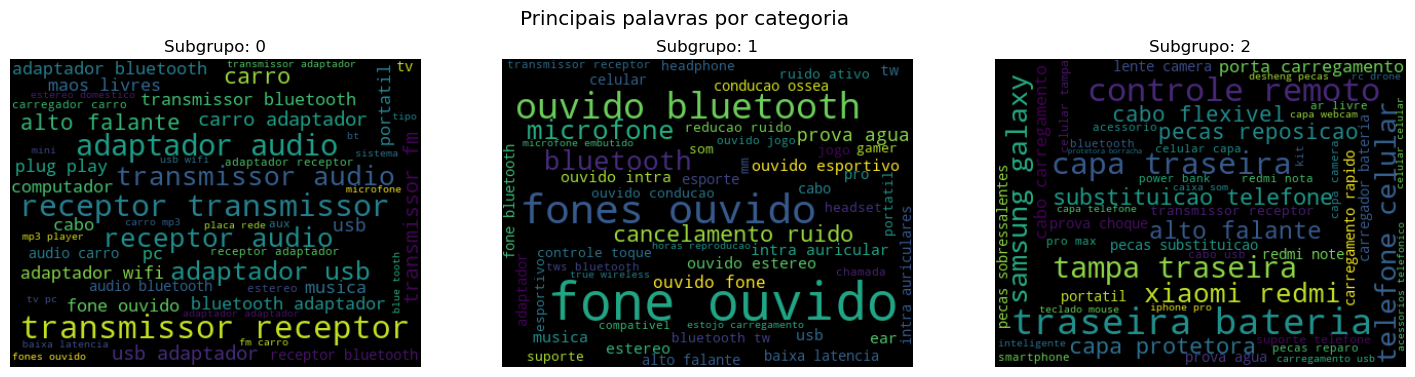

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    vectorizer = TfidfVectorizer(tokenizer=tokenizer)
    docs_matrix = vectorizer.fit_transform(docs)
    
docs_kmeans = KMeans(n_clusters=3, max_iter=500, n_init=1, random_state=1116).fit(docs_matrix)
predicted_targets = docs_kmeans.labels_

fig,axs=plt.subplots(1,3,figsize=(18,4.2))

for i,target in enumerate(np.unique(predicted_targets)):
    ix = np.where(predicted_targets==target)[0]
    plot_wordcloud(docs[ix],ax=axs[i],title=f'Subgrupo: {target}')

fig.suptitle('Principais palavras por categoria',fontsize='x-large')   
plt.show()

## Agrupamento de anúncios

A hipótese seguinte foi testar a classificação automática dos anúncios utilizando categorias de produtos atribuídas manualmente a cada anúncio como alternativa à utilização das categorias informadas pelos vendedores. Para tanto, foi selecionada uma amostra de até 10 exemplos de cada categoria completa (categoria principal e até 5 subcategorias) para análise e anotação do tipo do produto. 

Foram selecionados aleatoriamente 2.091 exemplos de anúncios. Cada um foi analisado visualmente a atribuída uma categoria, conforme o tipo de produto anunciado. Foram identificados 29 tipos de produtos, a maioria dos produtos não passíveis de homologação compulsória pela Anatel. 
 

|Tipo de Produto|Quantidade|
|:--------------|---------:|
|Outros|943|
|Transceptor de Radiação Restrita|599|
|Cabo (em geral)|89|
|Transceptor de RF (HF/VHF/UHF)|48|
|Microfone sem fio|38|
|Desktop/Notebook|30|
|Fone de ouvido sem fio|30|
|Carregadores e fontes (eletrônicos em geral)|27|
|Câmera sem fio|26|
|Carregador de celular|26|
|Impressora e cartuchos|25|
|Roteador/Reforçador WiFi|25|
|Antena|23|
|Baterias (eletrônicos em geral)|21|
|Extensor de vídeo VGA/HDMI|18|
|Tablets|16|
|Carregador sem fio|14|
|Telefone celular|14|
|Transceptor/Conversor SFP|14|
|Cartão de memória|13|
|Drone|12|
|Smartwatch|10|
|Carregador portátil (powerbank)|9|
|Cabo de rede|6|
|Reforçador de sinal de celular|5|
|Smart TV|4|
|Hub Switch|2|
|Modem 3G/4G/WiFi|2|
|TV Box|2|

A grande quantidade de tipos de produtos com poucos exemplos torna o processo de aprendizagem de máquina ineficiente pois há grande sobreposição de exemplos, tornando difícil a correta identificação do produto. Esse cenário já era esperado pois alguns tipos de produtos podem ser passívels de homologação compulsória pela Anatel em determinadas aplicações e, ao mesmo, não passíveis de homologação em outros cenários, como por exemplos, cabos, fontes, carregadores, baterias, etc.

Por outro lado, quando os produtos são agrupados em duas categorias (passíveis e não passíveis de homologação compulsória) observa-se uma sepação entre os grupos, indicando a viabilidade de construção de um classificador. Quando observadas as palavras mais frequentes em cada categoria observa-se que há palavras discriminantes das categorias, contudo, palavras presentes em mais de uma categoria (cabo, bateria, etc) demonstram a sobreposição observada no espaço vetorial.

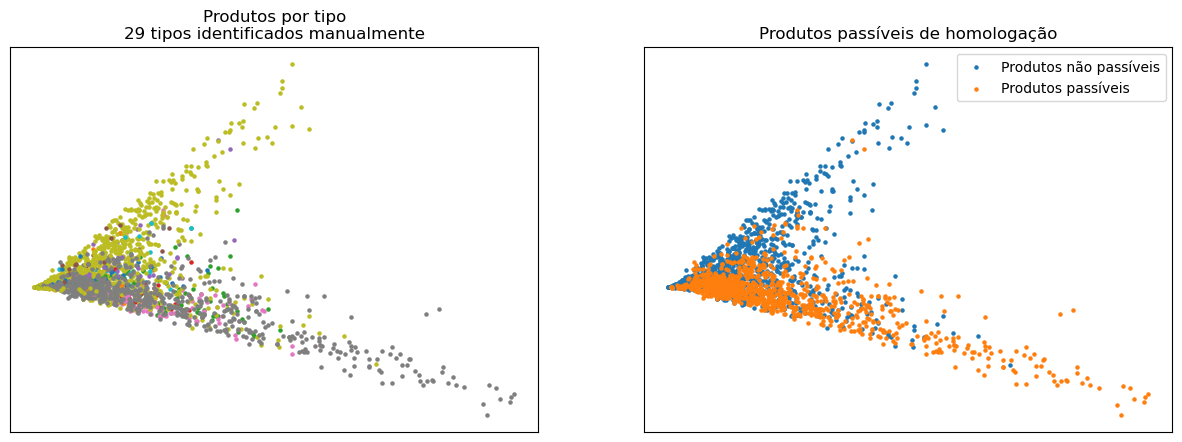

In [45]:
file_sample_to_label = 'assets/sample_to_label.parquet'
df_sample_to_label = pd.read_parquet(file_sample_to_label)

docs = df_sample_to_label['nome'].map(clean_text).values
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    vectorizer = TfidfVectorizer(tokenizer=tokenizer)
    docs_matrix = vectorizer.fit_transform(docs)

produtct_type = df_sample_to_label['tipo_produto']
compulsory_certification = df_sample_to_label['passivel']

legend_map = {0: 'Produtos não passíveis', 1: 'Produtos passíveis'}

fig,axs = plt.subplots(1,2,figsize=(15,5))
plot_produtcs_matrix(docs_matrix,targets=produtct_type,ax=axs[0],title='Produtos por tipo\n29 tipos identificados manualmente')
plot_produtcs_matrix(docs_matrix,targets=compulsory_certification,showlegend=True, legend_map=legend_map,ax=axs[1],title='Produtos passíveis de homologação')
plt.show()

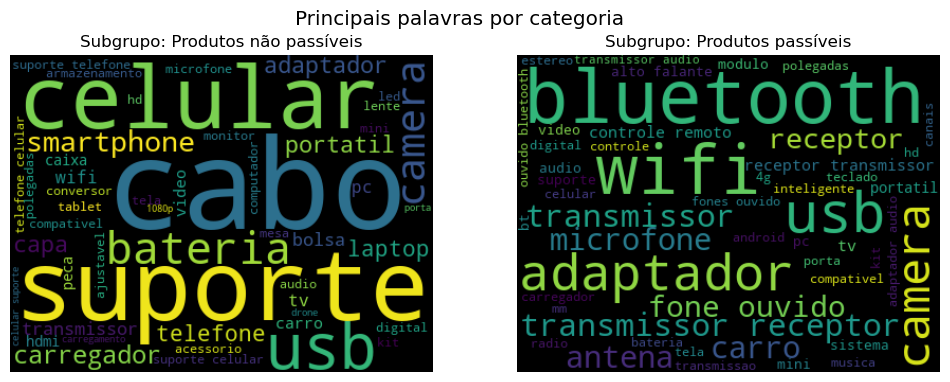

In [52]:
fig,axs=plt.subplots(1,2,figsize=(12,4.2))

for i,target in enumerate(np.unique(compulsory_certification)):
    ix = np.where(compulsory_certification==target)[0]
    plot_wordcloud(docs[ix],ax=axs[i],title=f'Subgrupo: {legend_map[target]}')

fig.suptitle('Principais palavras por categoria',fontsize='x-large')   
plt.show()